In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import plotly.express as px

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff



### BACKGROUND

Bạn là một Data Analyst làm việc cho một công ty thương mại điện tử tên là X. Bạn được giao nhiệm vụ chuẩn bị một bài thuyết trình để trình bày tổng quan tình hình kinh doanh và vận hành của công ty tính đến thời điểm hiện tại cho Giám đốc bán hàng và Giám đốc vận hành. Bài thuyết trình tối thiểu phải bao gồm các thông tin sau: tổng quan tình hình kinh doanh, mức độ hài lòng của khách hàng, và đề xuất 2 đến 3 lĩnh vực (areas) mà công ty có thể cải thiện. 

### DATA SET

After reading the document I managed to draw the ER diagram for the datasets
 + The customers table is the dim table contains information about each customers. It connects to the orders table with an one-to-many relationship
 + The orders table is the main (fact) table that we will be focusing on. It connects to three other tables with an one-to-many relationship: orders_reviews, order_payments and order_items
 + The products table connects to the order_items table with a connection of one-to-many
 + Finally, the product_category_name_translation is a weak-entity, it cannot exist without the products table. It connects to the products table.


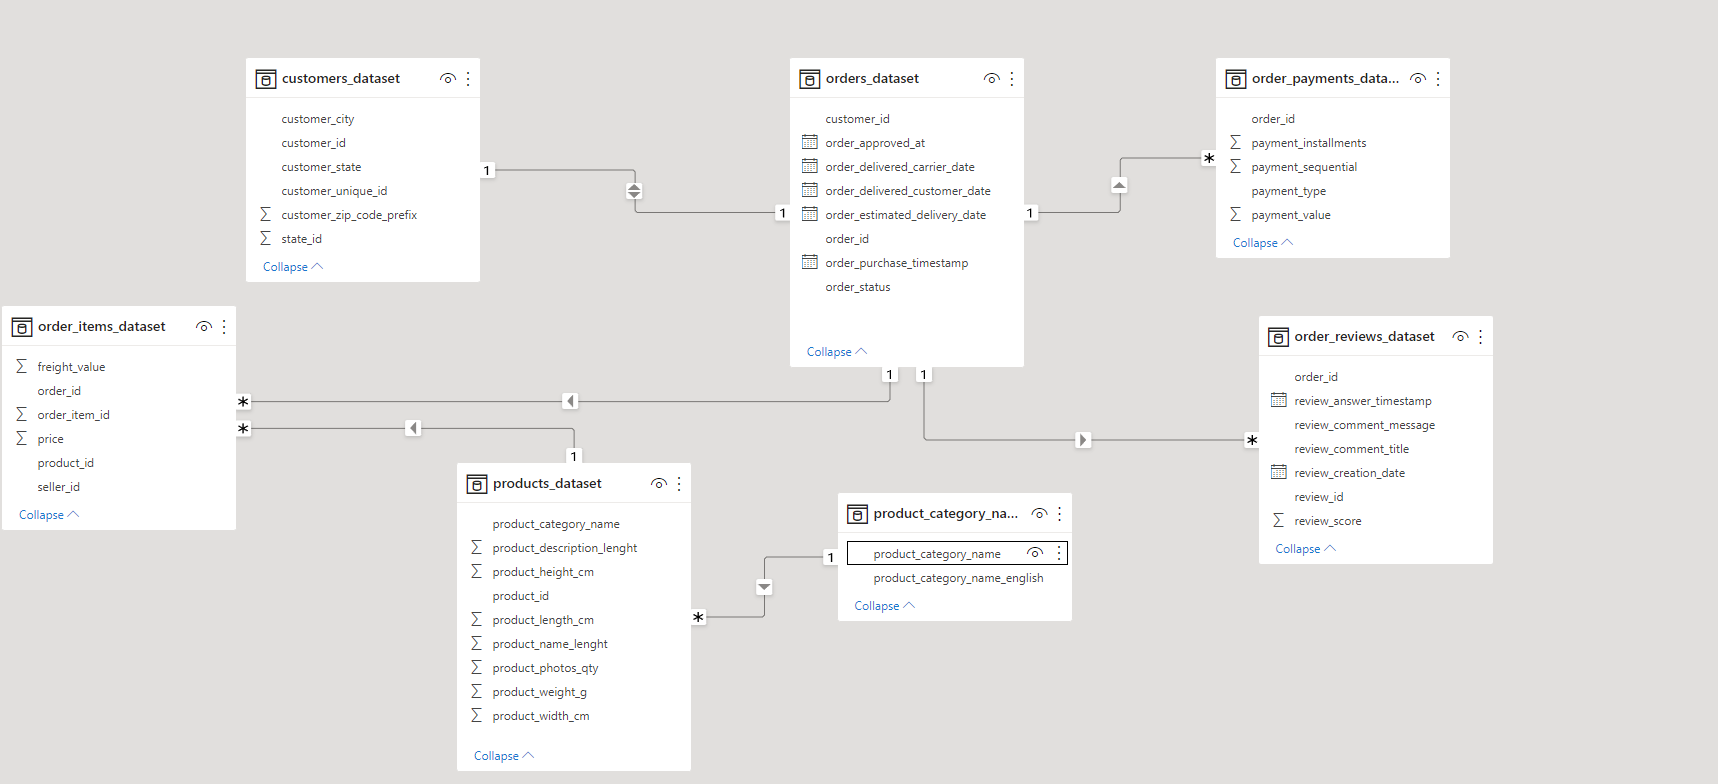

### IMPORTING AND CLEANING DATA

In [2]:
#Reading the database
Product = pd.read_csv(r'products_dataset.csv')
Product_category = pd.read_csv(r'product_category_name_translation.csv')
Orders = pd.read_csv(r'orders_dataset.csv')
Order_review = pd.read_csv(r'order_reviews_dataset - order_reviews_dataset (2).csv')
Order_payment = pd.read_csv(r'order_payments_dataset.csv')
Order_item = pd.read_csv(r'order_items_dataset.csv')
Customer = pd.read_csv(r'customers_dataset.csv')
Product_E_category=pd.read_csv(r'product_category_name_translation.csv')
geojson = json.load(open('brazil_geo.json'))

In [3]:
#Checking the null value

datasets = [Product, Product_category, Orders, Order_review, Order_payment, Order_item, Customer]
titles = ["Product","Product_category", "Orders","Order_review","Order_payment","Order_item","Customer"]

#To gather practical information about all datasets 
info_df = pd.DataFrame({},)
info_df['dataset']= titles
info_df['cols'] = [', '.join([col for col, null in df.isnull().sum().items() ]) for df in datasets]
info_df['cols_no']= [df.shape[1] for df in datasets]
info_df['null_no']= [df.isnull().sum().sum() for df in datasets]
info_df['null_cols_no']= [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
info_df['null_cols'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]


info_df.style.background_gradient(cmap='coolwarm')

,dataset,cols,cols_no,null_no,null_cols_no,null_cols
0,Product,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",9,1838,7,"product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
1,Product_category,"product_category_name, product_category_name_english",2,0,0,
2,Orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,Order_review,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",7,146543,2,"review_comment_title, review_comment_message"
4,Order_payment,"order_id, payment_sequential, payment_type, payment_installments, payment_value",5,0,0,
5,Order_item,"order_id, order_item_id, product_id, seller_id, price, freight_value",6,0,0,
6,Customer,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state, state_id",6,0,0,


#### The Order_review table.

In [33]:
Order_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [4]:
Order_review.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88287
review_comment_message     58256
review_creation_date           0
review_answer_timestamp        0
dtype: int64

We do not need the information in "review_comment_title" and "review_comment_message". So, we will drop these columns using drop() function 

In [4]:
Order_review = Order_review.drop(columns=['review_comment_title', 'review_comment_message'])

In [6]:
Order_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_creation_date     100000 non-null  object
 4   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


#### The Product table

In [7]:
Product.isnull().sum()

product_id                      0
product_category_name           0
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In this table, we only need the data of 2 columns "product_id" and "product_category_name". So we decide to keep these and drop another columns in the Product table

In [5]:
Product = Product.drop(columns=['product_name_lenght', 'product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm'])

In [10]:
Product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   product_id             32951 non-null  object
 1   product_category_name  32951 non-null  object
dtypes: object(2)
memory usage: 515.0+ KB


#### The Orders table

In [11]:
Orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [12]:
# viewing the dimensions of the dataset
Orders.shape

(99441, 8)

Since we have less than 20% missing values in the column, we just remove the rows which have missing values using the dropna() function from the Pandas library.

In [6]:
Orders=Orders.dropna()

In [14]:
Orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96461 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       96461 non-null  object
 1   customer_id                    96461 non-null  object
 2   order_status                   96461 non-null  object
 3   order_purchase_timestamp       96461 non-null  object
 4   order_approved_at              96461 non-null  object
 5   order_delivered_carrier_date   96461 non-null  object
 6   order_delivered_customer_date  96461 non-null  object
 7   order_estimated_delivery_date  96461 non-null  object
dtypes: object(8)
memory usage: 6.6+ MB


Now, we will convert the data type of "order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date","order_delivered_customer_date", "order_estimated_delivery_date"

### Merging the tables

In [7]:
df= Orders.merge(Order_item, on=['order_id'], how='left')
df= df.merge(Order_payment, on=['order_id'], how= 'left')
df= df.merge(Product, on=['product_id'], how= 'left')
df= df.merge(Order_review, on=['order_id'], how='left')
df= df.merge(Customer, on=['customer_id'], how='left')
df= df.merge(Product_E_category, on=['product_category_name'], how='left')
df = df.dropna()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115688 entries, 0 to 115713
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115688 non-null  object 
 1   customer_id                    115688 non-null  object 
 2   order_status                   115688 non-null  object 
 3   order_purchase_timestamp       115688 non-null  object 
 4   order_approved_at              115688 non-null  object 
 5   order_delivered_carrier_date   115688 non-null  object 
 6   order_delivered_customer_date  115688 non-null  object 
 7   order_estimated_delivery_date  115688 non-null  object 
 8   order_item_id                  115688 non-null  int64  
 9   product_id                     115688 non-null  object 
 10  seller_id                      115688 non-null  object 
 11  price                          115688 non-null  float64
 12  freight_value                 

In [9]:
def datetime_convert(columns, df):
    df[columns] = \
    df[columns].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

In [10]:
datetime_convert(\
    ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date','review_creation_date','review_answer_timestamp'],df)


#### Insert Month and Year column 

In [11]:
df['month']= pd.to_datetime(df['order_delivered_customer_date']).dt.month
df['year']= pd.to_datetime(df['order_delivered_customer_date']).dt.year

#### Insert "TimeToDeliveryinHours" column

In [12]:
df["TimeToDeliveryinHours"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"])
df["TimeToDeliveryinHours"] = df["TimeToDeliveryinHours"].apply(lambda x: x.total_seconds())
df["TimeToDeliveryinHours"] = round((df["TimeToDeliveryinHours"] / 3600) / 24, 2)
df.rename(columns={"TimeToDeliveryinHours" : "TimeToDeliveryinDays"}, inplace=True)

#### Insert "is_delayed" column

column 'is_delayed' is the column to represent the ratio between the total number of orders delivered on time and the total number of late orders according to each customer ID

In [13]:
tmp = df[['customer_id','order_delivered_customer_date','order_estimated_delivery_date']]
tmp['is_delayed'] = df['order_delivered_customer_date'] > df['order_estimated_delivery_date']
is_delayed = tmp.groupby('customer_id')['is_delayed'].sum()/tmp.groupby('customer_id')['is_delayed'].count()

In [14]:
df= df.merge(is_delayed, on=['customer_id'], how= 'left')

In [15]:
df['delivery_time'] = (df['order_delivered_customer_date']-df['order_delivered_carrier_date']).dt.days.to_frame()

#### Insert the "answer_time" column

In [16]:
df['answer_time'] = (df['review_answer_timestamp'] - df['review_creation_date']).dt.days.to_frame()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115688 entries, 0 to 115687
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115688 non-null  object        
 1   customer_id                    115688 non-null  object        
 2   order_status                   115688 non-null  object        
 3   order_purchase_timestamp       115688 non-null  datetime64[ns]
 4   order_approved_at              115688 non-null  datetime64[ns]
 5   order_delivered_carrier_date   115688 non-null  datetime64[ns]
 6   order_delivered_customer_date  115688 non-null  datetime64[ns]
 7   order_estimated_delivery_date  115688 non-null  datetime64[ns]
 8   order_item_id                  115688 non-null  int64         
 9   product_id                     115688 non-null  object        
 10  seller_id                      115688 non-null  object        
 11  

### EDA

## Business Situation

### Reveune by Year


In [18]:
turnover_year= df.groupby('year')['payment_value'].sum().reset_index()
xs,ys= turnover_year['year'], turnover_year['payment_value']

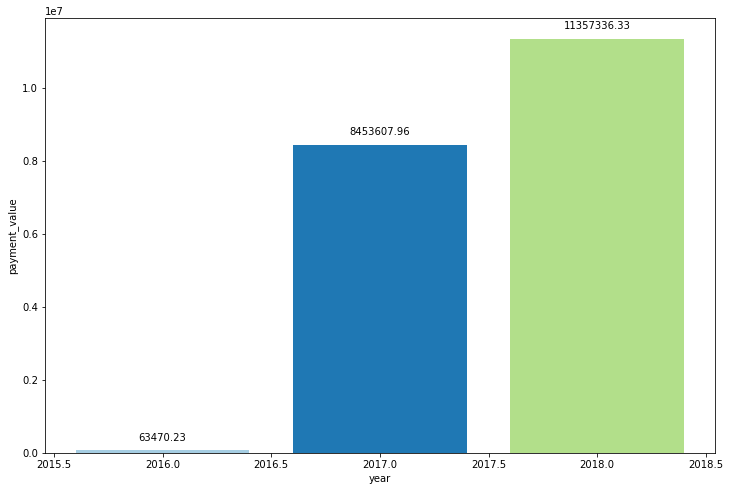

In [19]:
plt.figure(figsize=(12,8))
plt.bar(xs,ys, color= sns.color_palette('Paired'));
plt.xlabel('year')
plt.ylabel('payment_value')
for x,y in zip(xs,ys):
    
        label = "{:.2f}".format(y)

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

plt.show()

    

### Sales Trend


In [20]:
revenue = df.pivot_table(index = 'month', columns = 'year' , values = 'payment_value', aggfunc = 'sum')

<AxesSubplot:xlabel='month'>

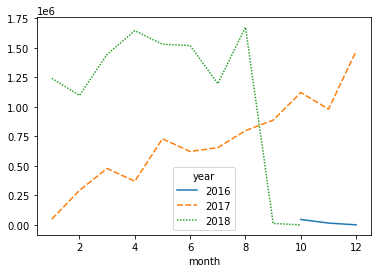

In [21]:
sns.lineplot(data=revenue)

### Revenue by States

#### Top States by Total Payments


In [22]:
top_ordersbyvalue_state = df.groupby("customer_state")["payment_value"].sum().reset_index().sort_values("payment_value", ascending=False)
top_ordersbyvalue_state["% of Total Payments"] = (top_ordersbyvalue_state["payment_value"] / top_ordersbyvalue_state["payment_value"].sum()) * 100
top_ordersbyvalue_state["Sum % of Total Payments"] = top_ordersbyvalue_state["% of Total Payments"].cumsum() 

Text(0.5, 1.0, 'TOP 10 States by revenue generation')

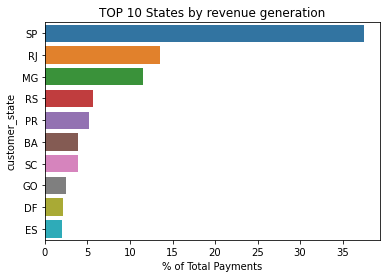

In [23]:
ax = sns.barplot(x="% of Total Payments", y="customer_state", data=top_ordersbyvalue_state[:10])
ax.set_title("TOP 10 States by revenue generation")

<Figure size 2400x1600 with 0 Axes>

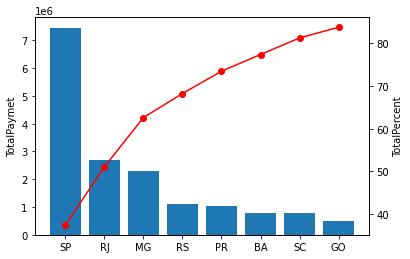

In [24]:
plt.figure(figsize=(30,20),dpi=80)
fig,ax=plt.subplots()
ax.bar('customer_state', 'payment_value' , data = top_ordersbyvalue_state[:8] )
ax.set_ylabel("TotalPaymet")

ax2=ax.twinx()
ax2.plot('customer_state', 'Sum % of Total Payments', data = top_ordersbyvalue_state[:8], marker='o', color='red' )
ax2.set_ylabel("TotalPercent")
plt.show()

As we can see, only 8/27 states account for more than 80% of the company's revenue. So, what happened to the rest of the states?

In [25]:

#Prepare data to display information on the map

gp = df.groupby('customer_state')['payment_value'].sum().to_frame()

gf = df.groupby('customer_state')['freight_value'].sum().to_frame()

tmp = df[['customer_state','order_delivered_customer_date','order_delivered_carrier_date']]
tmp['delivery_time'] = (df['order_delivered_customer_date']-df['order_delivered_carrier_date']).dt.days.to_frame()
gdt = tmp.groupby('customer_state')['delivery_time'].mean().to_frame()

rs = df.groupby('customer_state')['review_score'].mean().to_frame()
cc = df.groupby('customer_state')['customer_id'].count().to_frame()
cc = cc.rename(columns={'customer_id':'customer_count'})

order_status = df.groupby('customer_state')['order_status'].value_counts()/df.groupby('customer_state')['order_status'].count()
order_status = order_status.unstack().fillna(0)['delivered'].to_frame()

# Find out the ratio between delivery delays.
tmp = df[['customer_state','order_delivered_customer_date','order_estimated_delivery_date']]
tmp['is_delayed'] = df['order_delivered_customer_date'] > df['order_estimated_delivery_date']
is_delayed = tmp.groupby('customer_state')['is_delayed'].sum()/tmp.groupby('customer_state')['is_delayed'].count()


state_analysis = pd.merge(gp, gf,left_index=True,right_index=True,how='left')
state_analysis = pd.merge(state_analysis, gdt,left_index=True,right_index=True,how='left')
state_analysis = pd.merge(state_analysis, rs,left_index=True,right_index=True,how='left')
state_analysis = pd.merge(state_analysis, cc,left_index=True,right_index=True,how='left')
state_analysis = pd.merge(state_analysis, order_status,left_index=True,right_index=True,how='left')
state_analysis = pd.merge(state_analysis, is_delayed,left_index=True,right_index=True,how='left')


In [26]:
state_analysis

,payment_value,freight_value,delivery_time,review_score,customer_count,delivered,is_delayed
customer_state,,,,,,,
AC,24890.49,3759.67,16.840426,4.127660,94,1.000000,0.031915
AL,108727.76,15869.56,20.510112,3.804494,445,1.000000,0.244944
AM,34586.18,5634.52,23.258824,3.735294,170,1.000000,0.041176
AP,21521.71,2841.59,24.048193,3.939759,83,1.000000,0.048193
BA,776256.57,104328.26,15.364810,3.846076,3950,1.000000,0.137468
CE,334911.36,48805.44,17.024617,3.882236,1503,1.000000,0.150366
DF,424872.44,51586.91,9.214548,4.038006,2447,1.000000,0.073151
ES,399308.36,50863.96,11.779983,3.979724,2318,1.000000,0.121225
GO,497367.84,54027.26,11.817537,3.990814,2395,1.000000,0.078497


To concretize the business's revenue situation, we will use the map to show the revenue breakdown by state.

In [27]:
def plot_state_choropleth_map(data_frame, locations, geojson, color, color_continuous_scale='Reds', height=700,width=700):
    fig = px.choropleth(data_frame=data_frame, locations=locations, geojson=geojson, color=color, color_continuous_scale=color_continuous_scale, scope="south america")
    fig.update_layout(height=height, width=width,
                  title=f"<b>Brazilian E-Commerce Geolocation for {color}</b>",
                  geo=dict(lonaxis = dict(range= [-33.0, -80.0]),lataxis = dict(range= [5.0, -35.0])))
    fig.show()

In [29]:
#plot_state_choropleth_map(data_frame=state_analysis, locations=state_analysis.index, geojson=geojson, color="payment_value")

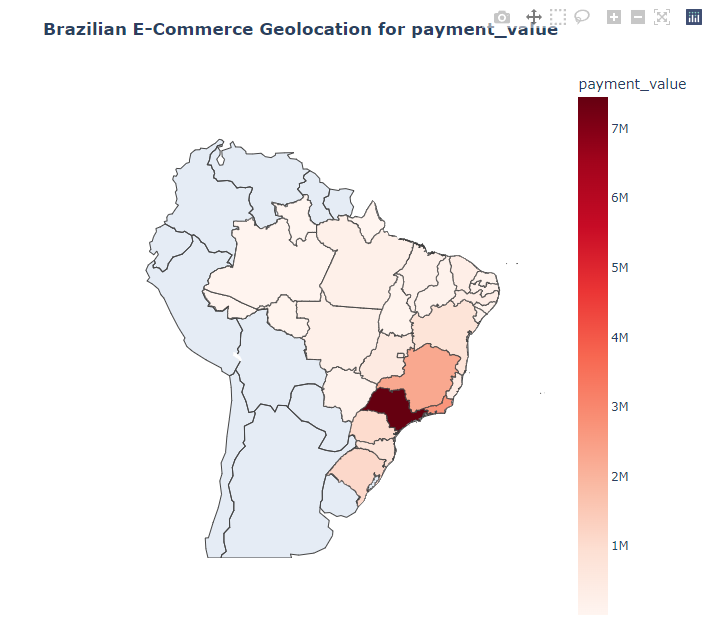

## Improve The Weaknesses


### Customer Satisfaction

In [27]:
avgRS = df['review_score'].mean()
print('Average review score is {}'.format(avgRS))

Average review score is 4.058675057049997


In [31]:
#plot_state_choropleth_map(data_frame=state_analysis, locations=state_analysis.index, geojson=geojson, color="review_score")

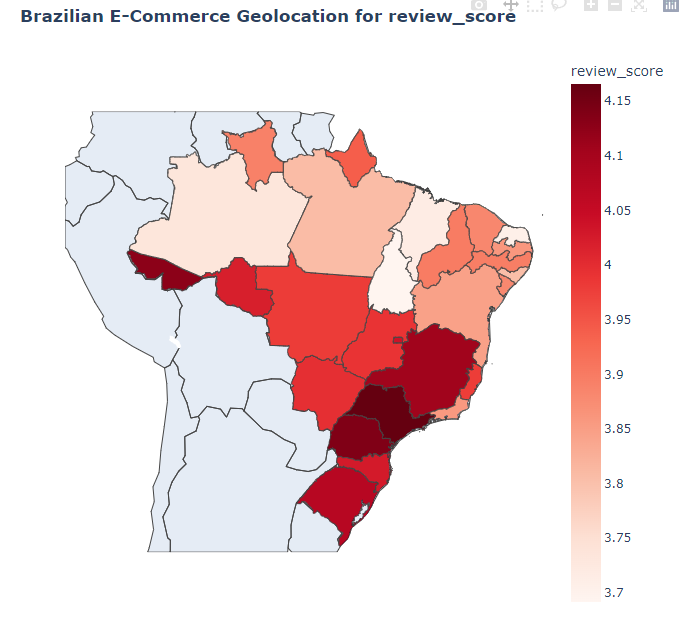

In next section, we will find out what factors are adversely affecting "review_score" and provide solutions to overcome that factor.

### What factors affect "review_score"?

In my opinion, the factors affecting customer evaluation are:
  - High shipping fee (Freight_value)
  - response time (answer_time)
  - Delivery time.

using "heatmap" to find the correlation to see which factor has the most influence on "review_score"

<AxesSubplot:>

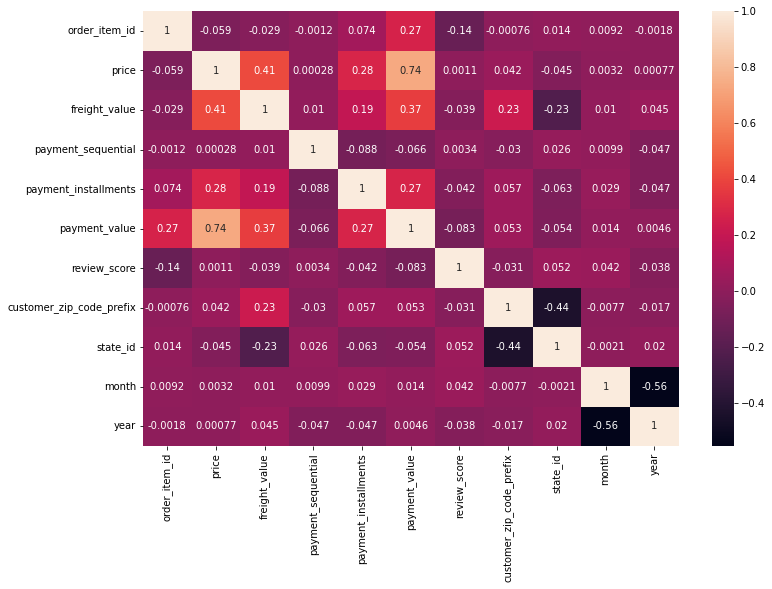

In [25]:
plt.figure(figsize = (12, 8))
sns.heatmap(df.corr(),  annot = True)

We can see, the corrleation between the element "TimeToDeliveryinDays" and "score_review" is a negative relationship, which means that the higher the delay in delivery, the lower the review score.

We will learn more about the relationship between "TimeToDeliveryinDays" and "score_review"

<AxesSubplot:xlabel='review_score', ylabel='TimeToDeliveryinDays'>

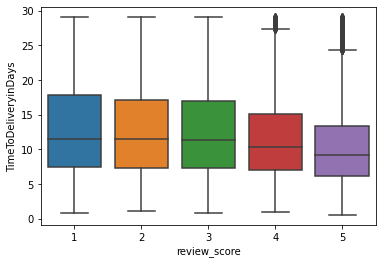

In [29]:
q_high = df["TimeToDeliveryinDays"].quantile(0.95)
data_no_outliers = df[df["TimeToDeliveryinDays"] < q_high]
sns.boxplot(x="review_score", y="TimeToDeliveryinDays", data=data_no_outliers)

Our initial hypothesis is confirmed. We can clearly see a direct relationship between timetodelivery and review_score. As the delivery time decreases, the review_score tends to go higher.

In [33]:
#plot_state_choropleth_map(data_frame=state_analysis, locations=state_analysis.index, geojson=geojson, color="is_delayed")

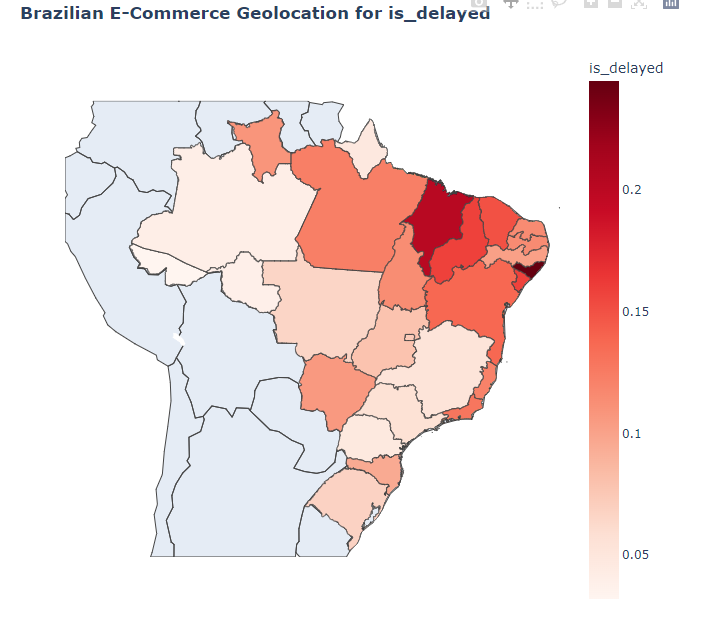

### Solution

In [68]:
#a = df.loc[df.customer_state == "RJ",:].groupby('customer_state')['payment_value'].sum().to_frame()
#b = df.loc[df.customer_state == "RJ",:].groupby('customer_state')['is_delayed'].mean().to_frame()
#c = R = df.loc[df.customer_state == "RJ",:].groupby('customer_state')['review_score'].mean().to_frame()
#RJ = pd.merge(a, b,left_index=True,right_index=True,how='left')
#RJ = pd.merge(RJ, c,left_index=True,right_index=True,how='left')

As we have demonstrated, the longer the delivery time, the lower the "review_score" will be.
==> Solutin: xây dựng thêm các kho bãi tại các bang và trải dài khắp cả nước, nhưng công ty chỉ mới thành lập được 2 năm nên việc xây dựng quy mô lớn như vậy là không thích hợp, công ty chỉ có thể tìm ra nơi ưu tiên cần đầu tư để phát triển kho bãi để khắc phục các vấn đề giao hàng. 

In which state should we prioritize building warehouses?

In [78]:
#map1=plot_state_choropleth_map(data_frame=RJ, locations=RJ.index, geojson=geojson, color="payment_value")
#map2=plot_state_choropleth_map(data_frame=RJ, locations=RJ.index, geojson=geojson, color="review_score")
#map3=plot_state_choropleth_map(data_frame=RJ, locations=RJ.index, geojson=geojson, color="is_delayed")

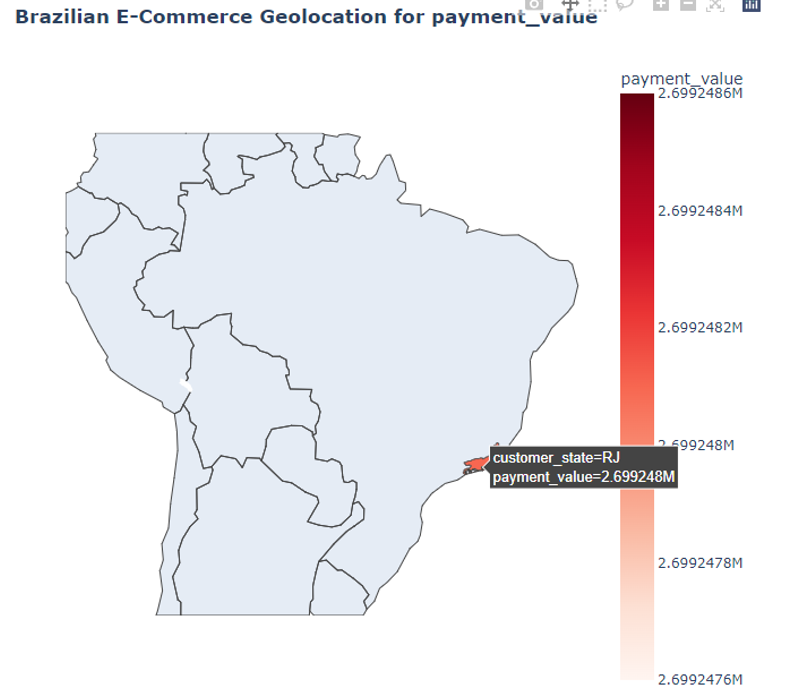

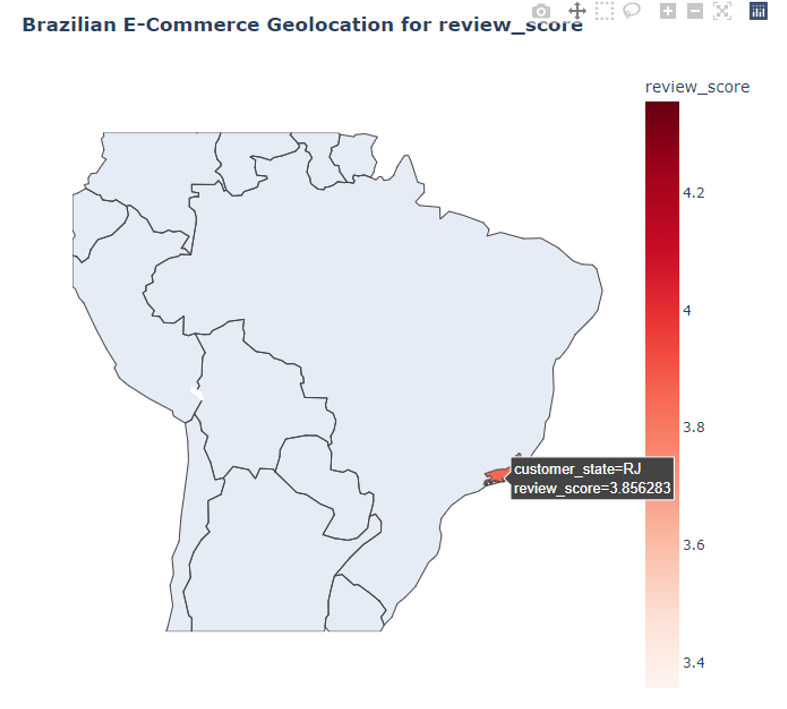

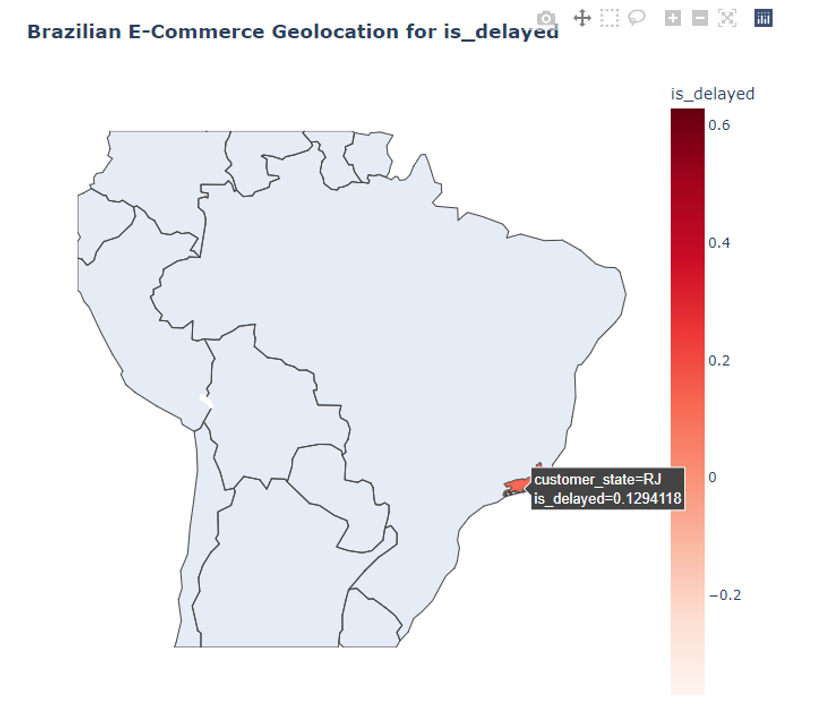

In [145]:
state_analysis.sort_values('payment_value', ascending = False).head(2)

,payment_value,freight_value,delivery_time,review_score,customer_count,delivered,is_delayed
customer_state,,,,,,,
SP,7453421.13,739767.56,5.075030,4.165717,48794,0.999959,0.056421
RJ,2699248.10,314912.58,11.383957,3.856283,14960,0.999799,0.129412


Through 3 maps, we determined that we should prioritize building more warehouses in the states: RJ

- Explain why:
  + RJ state has the 2nd largest revenue among all states (2.7m), but the late delivery rate in this area is quite high (0.13) and the evaluation time in RJ state is also quite low (3.8/5).
  + These states are located near 2 states with high sales and the least delivery time, which are SP and MG. It's easier to build more warehouses in the neighboring states of these two states, and we can take advantage of the infrastructure of those two states.
  + Build more warehouses at the mentioned warehouses for the purpose of increasing delivery quality thereby improving "review_score" in the above areas

## Develop the Strengths

### How do orders vary across time?


#### Total Order by hour.

In [34]:
Orders["order_purchase_timestamp"] = pd.to_datetime(Orders["order_purchase_timestamp"])
orderbyhour = Orders.groupby(Orders["order_purchase_timestamp"].dt.hour)["order_id"].count().reset_index().sort_values(by="order_purchase_timestamp", ascending=False)
orderbyhour.rename(columns={"order_id":"Total Orders", "order_purchase_timestamp": "Hour of Day"}, inplace=True)

Text(0.5, 1.0, 'Total Orders by hour')

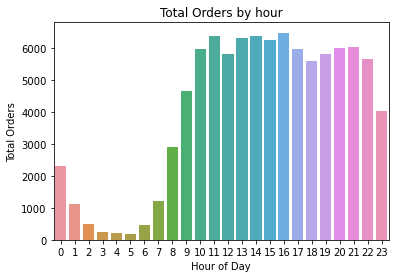

In [35]:
ax = sns.barplot(x="Hour of Day", y="Total Orders", data=orderbyhour)
ax.set_title("Total Orders by hour")

The Total Orders increase from 6A.M to 4P.M, We can give more vouchers in the remaining hours to increase Orders 

#### Total Order by month.

In [31]:
totalorder = df.pivot_table(index = 'month', columns = 'year' , values = 'order_id', aggfunc = 'count')

Text(0.5, 1.0, 'Total Orders by Month')

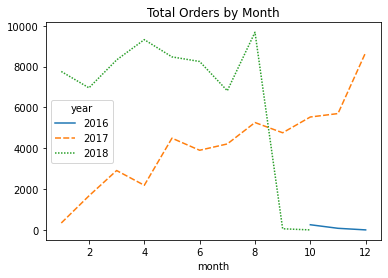

In [37]:
ay = sns.lineplot(data=totalorder)
ay.set_title("Total Orders by Month")

Apply points loyatly programs in peak months, and apply some promotions when shopping in peak months. Give customers a reason to come back next month.

### Category 

#### What are the most sold categories of product?

Text(0.5, 1.0, 'Total revenue made by top 10 categories')

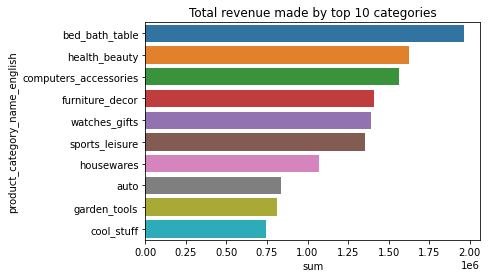

In [75]:
top_categories = df.groupby('product_category_name_english')['payment_value'].sum().reset_index().sort_values("payment_value",ascending=False).head(10)
top_categories.rename(columns={"payment_value":"sum"}, inplace=True)
ax = sns.barplot(x="sum", y="product_category_name_english", data=top_categories)
plt.title('Total revenue made by top 10 categories')


### Top 5 categories with highest and lowest growth

In [95]:
a1 = df[df.year > 2016]


In [82]:
performance = a1.pivot_table(index = 'product_category_name_english', columns = 'year' , values = 'payment_value', aggfunc = 'sum')

In [84]:
performance['growth'] = (performance[2018] - performance[2017])/performance[2017]*100

In [129]:
top_5_highest_category = performance.sort_values('growth', ascending = False).head(5)
top_5_lowest_category = performance.sort_values('growth', ascending = True).head(5)


year,2017,2018,growth
product_category_name_english,,,
small_appliances_home_oven_and_coffee,795.87,49485.78,6117.822006
diapers_and_hygiene,199.40,3775.78,1793.570712
construction_tools_lights,4656.26,65941.52,1316.190677
drinks,5863.38,63542.83,983.723552
arts_and_craftmanship,218.63,2107.54,863.975667


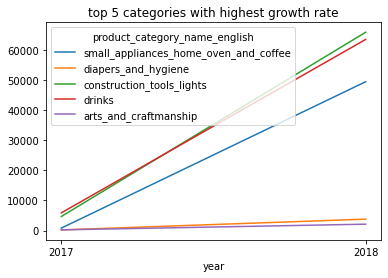

In [153]:
top_5_highest_category.drop(columns = 'growth').transpose().plot()
plt.xticks([2017,2018])
plt.title('top 5 categories with highest growth rate');

top_5_highest_category

Suggestion: Focus more on 2 categories:
  + small_appliances_home_oven_and_cofffee
  + construction_tools_flight
- Although construction_tools_flight only stand in number 4 but it brings success at large scale (more than 37000 revenue made  in 2018), while the other 3 only success at relatively small scale


year,2017,2018,growth
product_category_name_english,,,
cds_dvds_musicals,1081.85,117.58,-89.131580
fashion_sport,3139.55,505.37,-83.903107
tablets_printing_image,8072.67,1970.26,-75.593453
fashion_male_clothing,13102.68,3584.92,-72.639796
home_comfort_2,1206.73,503.81,-58.249981


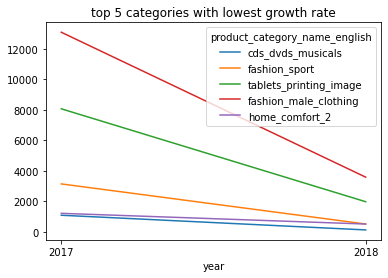

In [152]:
top_5_lowest_category.drop(columns = 'growth').transpose().plot()
plt.xticks([2017,2018])
plt.title('top 5 categories with lowest growth rate');
top_5_lowest_category

## Conculison


IMPROVEMENT OF CUSTOMER'RATING SCORE
- Consider changing shipping company
- Open more warehouse in RJ state to solve the delivery problem in that area as well as surrounding areas

DEVELOPMENT OF STRENGHTH.
- Offer more vouchers during high-traffic hours to increase sales. Building a "membership card" program and launching promotions in the last months of the year
- Consider developing categories with good growth and revenue, and consider low growth categories